In [2]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
# from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from pyURControl import ur_control
import math
import time
import roboticstoolbox as rtb
from spatialgeometry import Cylinder
from math import pi

# Link lengths (a)
a = [0.0, -0.24355, -0.2132, 0.0, 0.0, 0.0]

# Link twists (alpha)
alpha = [pi/2, 0.0, 0.0, pi/2, -pi/2, 0.0]

# Link offsets (d)
d = [0.15185, 0.0, 0.0, 0.13105, 0.08535, 0.0921]

In [3]:
collision_geometries = [
    Cylinder(radius=0.04, length=0.1518),  # Link 1
    Cylinder(radius=0.04, length=0.2435),  # Link 2
    Cylinder(radius=0.04, length=0.2132),  # Link 3
    Cylinder(radius=0.04, length=0.08535), # Link 4
    Cylinder(radius=0.04, length=0.13105), # Link 5
    Cylinder(radius=0.04, length=0.1000)   # Link 6
]

In [4]:
links = []
for i in range(6):
    link = rtb.RevoluteDH(d=d[i], a=a[i], alpha=alpha[i])
    links.append(link)

# Initialize the UR3e robot model
ur3e = rtb.DHRobot(links, name='UR3e')

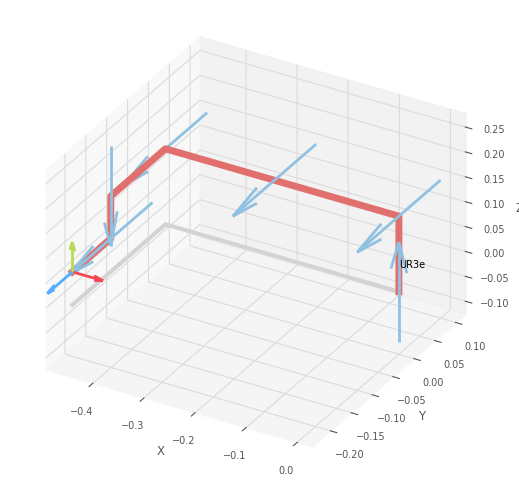

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR3e')

<Figure size 640x480 with 0 Axes>

In [ ]:
q = [0.0, 1.57, 0.0, 0.0, 0.0, 0.0]
ur3e.plot(q)

In [69]:
previous_q = None
previous_qd = None
initialized = False
def feedback(robot, dt):
    global previous_q, previous_qd, initialized 

    current_q = robot.q

    if previous_q is None:
        previous_q = current_q
        previous_qd = np.zeros_like(current_q)
        initialized = True
        ee_pose = robot.fkine(current_q).t
        return current_q, np.zeros_like(current_q), np.zeros_like(current_q), ee_pose, False

    qd = (current_q - previous_q) / dt
    qdd = (qd - previous_qd) / dt
    ee_pose = robot.fkine(current_q).t

    previous_q = current_q
    previous_qd = qd

    return current_q, qd, qdd, ee_pose, True

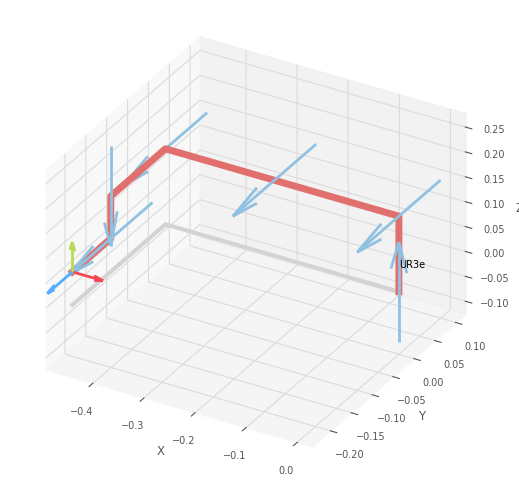

<Figure size 640x480 with 0 Axes>

In [70]:
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
# from stable_baselines3.common.env_checker import check_env
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from pyURControl import ur_control
import math
import time
import roboticstoolbox as rtb
from spatialgeometry import Cylinder
from math import pi
import matplotlib.pyplot as plt
import os
from roboticstoolbox.backends.PyPlot import PyPlot
from utility import reset,compute_reward,generate_cmd,PPOAgent
import torch

# Link lengths (a)
a = [0.0, -0.24355, -0.2132, 0.0, 0.0, 0.0]

# Link twists (alpha)
alpha = [pi/2, 0.0, 0.0, pi/2, -pi/2, 0.0]

# Link offsets (d)
d = [0.15185, 0.0, 0.0, 0.13105, 0.08535, 0.0921]

qlim = np.array([
    [-2*np.pi, 2*np.pi],  # Joint 1
    [np.pi, np.pi],  # Joint 2
    [np.pi, np.pi],  # Joint 3
    [-2*np.pi, 2*np.pi],  # Joint 4
    [-2*np.pi, 2*np.pi],  # Joint 5
    [-2*np.pi, 2*np.pi]   # Joint 6
])
# Create the list of links
links = []
for i in range(6):
    link = rtb.RevoluteDH(d=d[i], a=a[i], alpha=alpha[i])
    links.append(link)

# Initialize the UR3e robot model
ur3e = rtb.DHRobot(links, name='UR3e')
# ur3e.l
q = 6 * [0.0]


dt = 0.01  # 50 milliseconds
q = np.zeros(6)  # Initial joint positions

backend = PyPlot()
backend.launch()
backend.add(ur3e)
fig = backend.fig
ax = fig.axes[0]

cmd = generate_cmd()
for point in cmd:
    ax.scatter(point[0], point[1], point[2], color='red', marker='o', s=50)

def compute_next_q(q, qd, qd_prev, dt, max_acc):
    # Calculate the desired change in velocity
    delta_qd = qd - qd_prev

    # Compute the maximum allowable change in velocity
    max_delta_qd = max_acc * dt

    # Clip the change in velocity to the allowable range
    delta_qd_clipped = np.clip(delta_qd, -max_delta_qd, max_delta_qd)

    # Compute the new velocity
    qd_new = qd_prev + delta_qd_clipped

    # Update the joint positions
    q_new = q + qd_new * dt

    return q_new, qd_new

qd = np.array([0.0, 0.5, 0.0, 0.0, 0.0, 0.0])
q_log = []
qd_log = []
qdd_log = []
ee_log = []
max_joint_acceleration = np.deg2rad(300)  # Convert 300°/s² to radians
qd_prev = np.zeros(6)
currrent_q, currrent_qqd, currrent_qqdd,ee_pose ,valid= feedback(ur3e, dt)

for i in range(500) :
    # currrent_q, currrent_qqd, currrent_qqdd,ee_pose = feedback(ur3e, dt)
    # print(currrent_q, currrent_qqd, ee_pose)
    #  position control
    # q[0] += 0.01 


    # velo control
    # q += qd * dt

    # for j in range (6) : 
    #     if j == 1 or j == 2:
    #         if (-np.pi < currrent_q[j] < np.pi) : 
    #             q[j] += qd[j] * dt
    #     else : 
    #         q[j] += qd[j] * dt
    # current_q, current_qd, current_qdd, ee_pose = feedback(ur3e, dt)

    # Compute the next joint positions and velocities with acceleration limiting
    # q, qd_prev = compute_next_q(q, qd, qd_prev, dt, max_joint_acceleration)

    # ur3e.q = q
    
    # backend.step(dt)
    if i == 250 :
        qd = np.array([0.0, -1.0, 0.0, 0.0, 0.0, 0.0])
    q, qd_prev = compute_next_q(q, qd, qd_prev, dt, max_joint_acceleration)
    ur3e.q = q
    backend.step(dt)

    currrent_q, currrent_qqd, currrent_qqdd, ee_pose, valid = feedback(ur3e, dt)

    if not valid:
        continue  # Skip logging the first invalid step

    q_log.append(currrent_q)
    qd_log.append(currrent_qqd)
    qdd_log.append(currrent_qqdd)
    ee_log.append(ee_pose)

    

ee_log = np.array(ee_log)  # Convert list to NumPy array for easy slicing
q_log_np = np.array(q_log)
qd_log_np = np.array(qd_log)
qdd_log_np = np.array(qdd_log)
time = np.arange(len(q_log_np)) * dt  # Time vector

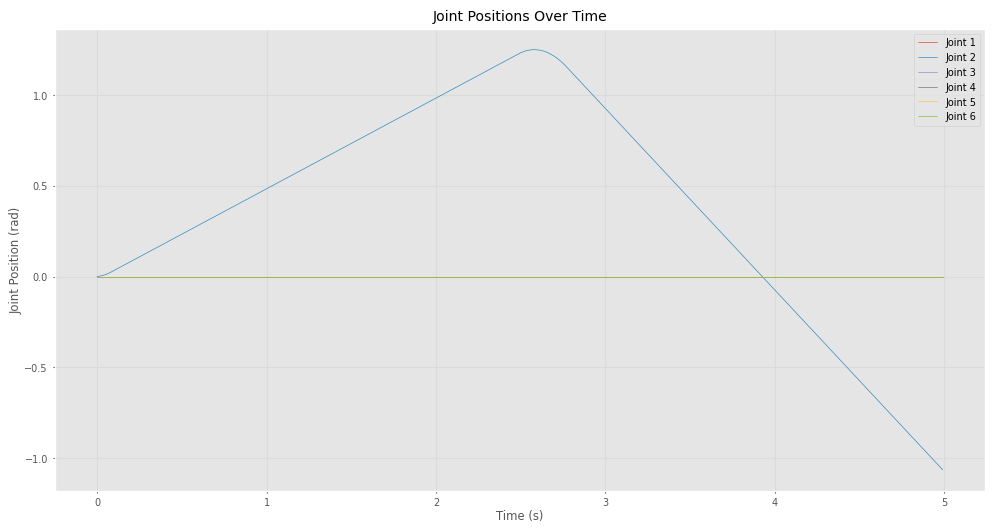

In [71]:
# Plot joint positions
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(time, q_log_np[:, i], label=f'Joint {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Position (rad)')
plt.title('Joint Positions Over Time')
plt.legend()
plt.grid(True)
plt.show()


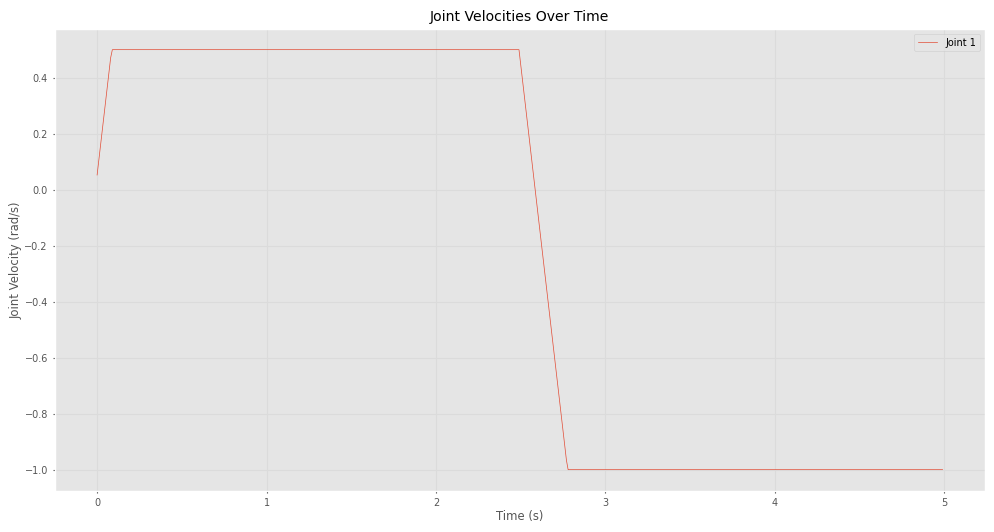

In [72]:
# Plot joint velocities
plt.figure(figsize=(12, 6))
# for i in range(6):
#     plt.plot(time, qd_log_np[:, i], label=f'Joint {i+1}')
# for i in range(6):
plt.plot(time, qd_log_np[:,1], label=f'Joint {1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Velocity (rad/s)')
plt.title('Joint Velocities Over Time')
plt.legend()
plt.grid(True)
plt.show()



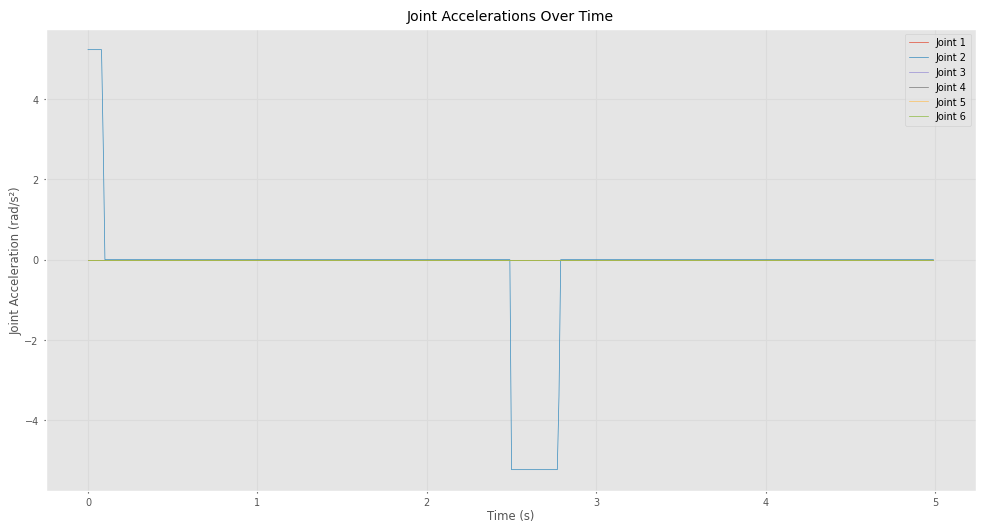

In [73]:
# Plot joint accelerations
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(time, qdd_log_np[:, i], label=f'Joint {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Acceleration (rad/s²)')
plt.title('Joint Accelerations Over Time')
plt.legend()
plt.grid(True)
plt.show()


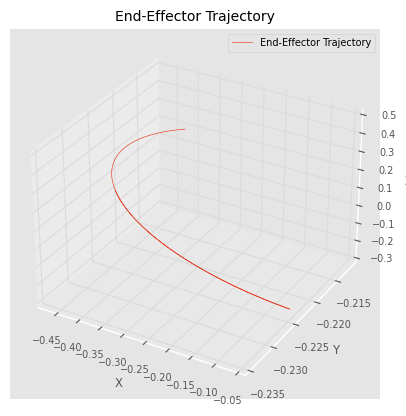

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ee_log[:, 0], ee_log[:, 1], ee_log[:, 2], label='End-Effector Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('End-Effector Trajectory')
ax.legend()
plt.show()